# Freeway Guide Sign Detection
## The Path:
* ### Train a support vector machine with features from images with and without signs
    * ### The features will be Histograms of Oriented Gradients
* ### Find regions of interest in which to use the classifier
    * ### We don't want to have to scan the whole image: it's time consuming
    * ### We will use traditional CV techniques such as filtering, thresholding, and finding contours to find ROIs
* ### Test the regions of interest with the classifier to see where the signs are


## Getting the images into a usable format

First get the imports. Some you may need to instal with pip (imutils in particular). data_generator.py is a file I wrote, see file in repo for details. %matplotlib inline is to force the images to be shown in the notebook.

In [38]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import data_generator as dg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline  

### Getting the positive images

Getting the positive images from the marked images: the images were found in freeway landscapes and marked by gLabels https://apps.ubuntu.com/cat/applications/precise/glabels/ producing a json file listing the parent image and coordinates.

You can crop these yourself, of course, and store them as well. Both take about the same amount of time.

dg.getImagesFromJSON is a function I wrote to do this; the details aren't important.

In [39]:
#get positive images, determine best ratios (rows over columns), assign to images
def remove_red(img):
    img[:,:,2] = 0
    return img

pimages = dg.getImagesFromJSON(open("labels.json").read())
pimages = [remove_red(x) for x in pimages]
print(len(pimages), "positive images")

270 positive images


### Getting the negative images

Generate negative images using functions in data_generator. I took random images from the sun database, as well as partial sign images (I don't want these to count as signs) by randomly cropping portions of sign images.

In [40]:
#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
partialsignimgs = dg.getRandomMultiple("partial", 200, 0)
nimages = nimages+partialsignimgs
nimages = [x[1] for x in nimages]

print(len(nimages), "negative images")


400 negative images


## The features 

We will be getting Histograms of Oriented Gradients from the images to use to train our classifiers

### Histogram of Oriented Gradients(HOG)
ref: https://www.learnopencv.com/histogram-of-oriented-gradients/ .
This is Satya Mallick's blog: he has many interesting and useful posts on computer vision --- check them out.


Also see the classic paper for pedestrian detection by Dalal and Triggs:http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf  

#### Intuition

We are looking for a *feature descriptor*: a way to represent useful information in our image to use in our classifier

HOGs are good at conveying information about the angles of edges: good when the objects to be detected have certain patterns such as circles, rectangles, etc. Objects with lots of corners are good candidates. Also, it's useful when objects are viewed straight on and not at a wide 
variety of perspectives.

#### Calculating HOG

#### Step 1: Preprocessing

All patches to be analized have to be of the same aspect ratio: if you want to detect objects with different aspect ratios, you'll have to do this whole process for each ratio

![](graphs/cropping.png)

To train on people like the runner, we have to decide on an aspect ratio, and use that throughout for a particular classifier. Also, the images are usually downsized as well, as this doesn't affect the amount of useful information we'll get from HOG features.


#### Step 2: Calculate the Gradient Images
We won't actually be doing this in today's example, as opencv does all this for us, but it's good to have an idea of what's going on behind the scenes.

First, calculate horizontal and vertical gradients, by filtering the image with the following kernels:

![](graphs/gradient-kernels.jpg)

What is meant by the above is to drag the above filter (called Sobel filter) over an image, and multiply the pixels underneath a value in the filter by the values, and applying a formula

![](graphs/angle.png)

This gives us a gradient value, along with the angle of the gradient. What this tells us intuitively is that there is sharp change in intensity, and the change can be measured with the above filter and formulas. These values are stored for all the pixels.

![](graphs/gradients.png)
Left : Absolute value of x-gradient. Center : Absolute value of y-gradient. Right : Magnitude of gradient. 

For color images like the above, three channels are evaluated, and the gradient at a pixel is the max of all the channels at that pixel, and the gradient angle is the angle of the max channel's gradient.

#### Step 3 : Calculate Histogram of Gradients in 8×8 cells

The image is divided into 8x8 cells, and a HOG is calculated for each cell:

![](graphs/hog-cells.png)

![](graphs/hog-cell-gradients.png)

Why?? 
Well, we don't want to have a set features for each pixel. So we'll do this for the 8x8 cells, and mathematically combine each of these together for a more compact representation. Each patch has 192 values. Eventually we'll pare this down to one 9-bin histogram. This process also helps resist noise in individual gradients.

Why 8x8? It doesn't have to be, but it's a logical choice, as it's big enough to contain the info we need. This can be changed, btw. Also, if you do use this, your image's dimensions must be divisible by 8.

The next step is to convert each of these 8x8 cells into 9-bin histograms. Each bin corresponds to an angle: 0, 20, 40, ... 160. (we only go to 180 (just mod the angle); going to 360 doesn't improve results.

Each gradient is examined in terms of it's angle. Then the proportion of its intensity is distributed to the bins on either side of the value, according to how proportionally close the value is to the bins.

e.g., a gradient of magnitude 4 and angle 30 will have 2 added to the 20 bin, and 2 added to the 40 bin, since 30 is halfway between 20 and 40. 

If the angle is right on a bin number, just add its value to that bin. Two more examples:

![](graphs/hog-histogram-1.png)

Then we get:

![](graphs/histogram-8x8-cell.png)

#### Step 4 : 16×16 Block Normalization
Gradients are sensitive to overall lighting. Divide all pixels by 2, and the gradients shrink. We need to normalize for this to resist lighting differences.

How to normalize a 3 channel pixel?

Divide each 3-d vector (array with 3 values) by:
    $$ \sqrt{c1^2 + c2^2 + c3^2}$$
    
The same would go for a 9-channel histogram. In practice, we do this for 16x16 blocks (their histograms --- convert to a vector of length 36 and normalize it like the 3-d vector).

#### Step 5 : Calculate the HOG feature vector
Finally, the 36x1 vectors are concatenated into one vector. This is your HOG feature vector!

If we plotted the dominant angle in the histograms for the 8-bin cells, we could get something like this:

![](graphs/hog-visualization.png)

#### What this means for sign detection
For my project, the intuition is that traffic guide signs will have a special pattern of dominant gradients unique to them, so that we can train a classifier on a vector describing these features to detect signs.


### Setting up the HOG class used to make HOGS

In [59]:
minDim = 80
dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims)

TypeError: bad argument type for built-in operation

### Geting the HOGs from our images

In [42]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


Below I just get hog features for all the images, concatenate pos and negs into an array, shuffle, then create train and test features and labels.

In [43]:
pdata = getFeaturesWithLabel(pimages, hog, dims, 1)
ndata = getFeaturesWithLabel(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))

train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])



## Training a classifier

### Classifier: Support Vector Machine (SVM)

Here I'll very briefly describe SVMs, though I will also leave out a lot of the mathematical details: see Prof. Pourhomayoun's class for those. (ref: https://www.kdnuggets.com/2017/08/support-vector-machines-learning-svms-examples.html)

![](graphs/svm1.png)
![](graphs/svm2.jpeg)


Find lines that correctly classify the training data
Among all such lines, pick the one that has the greatest distance to the points closest to it.


The closest points that identify this line are known as support vectors. And the region they define around the line is known as the margin.

Here’s the second line shown with the support vectors: points with black edges (there are two of them) and the margin (the shaded region).

![](graphs/svm3.png)

Note there is a tradeoff between the margin size, and number of misclassifications.

![](graphs/svm4.png)

This can be adjusted with the C value: the lower the C, the wider the
margin. Also, wider margins mean less overfitting, but lower accuracy on the training set.

![](graphs/svm5.png)

But what if the data isn't linerally seperable? We could engineer features that are not linear, or we can do the kernel trick.

Kernels:
ref: https://www.youtube.com/watch?v=mTyT-oHoivA --- a video from Andrew Ng, a ML legend.

A way to generate features automatically: compute a new feature for each training example depending on how far it is from a selected landmark point, as seen below:

![](graphs/svm6.jpg)

We can pass this distance into an additional function (e.g., gaussian) to produce a similarity function (gaussian makes points further from the landmark have less importance). 

A way to select landmark points is to simply make each example a landmark.

A linear kernel just finds a straight line without extra feature generation. That's what we'll use, as it's standard practice.


Creating a SVM, fitting it to our training data

In [44]:
lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(train_feat, train_label)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Compute and display training accuracy

In [45]:
print(lsvm.score(train_feat, train_label))

1.0


Compute and display test set accuracy, precision, recall, f1-score

In [46]:
#compute test accuracy
print("test accuracy ", lsvm.score(test_feat, test_label))
y_pred = lsvm.predict(test_feat)
print(classification_report(test_label, y_pred))

test accuracy  0.955223880597
             precision    recall  f1-score   support

          0       0.98      0.95      0.96        84
          1       0.92      0.96      0.94        50

avg / total       0.96      0.96      0.96       134



Confusion Matrix

In [47]:
confusion_matrix(y_pred, test_label)

array([[80,  2],
       [ 4, 48]])

## Detecting a Sign in a Landscape
### Image Preprocessing

In [48]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

Getting an image with some signs to detect, resizing it to make it more manageable.

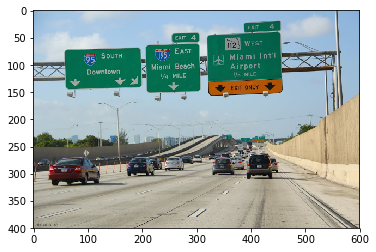

In [49]:
im = cv2.imread("multiscale_test/191.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

## Preprocessing
Preprocess image by filtering out colors (using our domain knowledge of guide signs)

In [50]:
def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0. The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

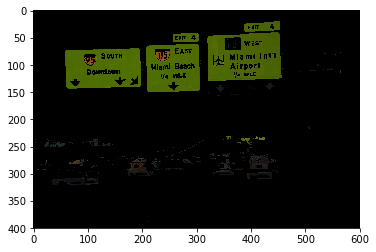

In [51]:
pimage, mask = preprocess(im,  [0,0,0], [255, 255, 40])
plt.imshow(pimage)
plt.show()

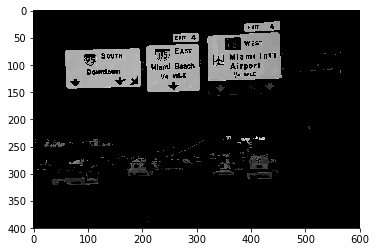

In [52]:
imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

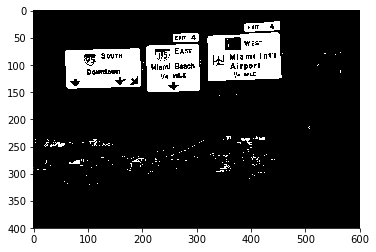

In [53]:
flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
plt.imshow(binaryImage, cmap='gray')
plt.show()

## Find Regions of Interest (ROI)

### Contours
Here is a contour map:
![](graphs/contour-map.jpg)

OpenCV's findContours function produces a list of contours (described by a series of points), and a hierarchy (which contours are inside other contours)

Super-brief explanation:

The contours algorithm used in cv2.findContours searches for borders, both on the outside of connected components (regions in a graph with connecting edges, or regions in a binary image of connected 0's or 1's), and on surrounded connected components, by passing over the image, detecting a border via detecting an edge, and numbering each border with a unique integer to keep them distinct. 

See: Topological Structural Analysis of Digitized Binary Images by Border Following by Satoshi Suzuki, 1985.

In [54]:
#the actual algorithm is described in 
im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

442
6


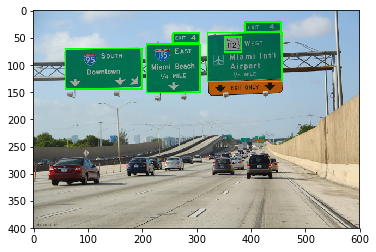

In [55]:
copy = im.copy()
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

Apply HOG to bounding boxes for result

In [56]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

In [57]:
real_signs = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = im[y:y+h, x:x+w, :3]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_signs.append((x,y,w,h))
    
print(len(real_signs))


6


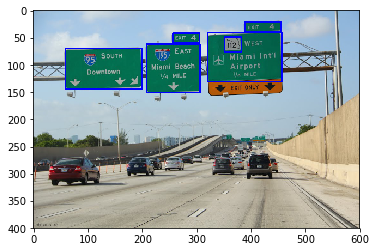

In [58]:
clone = im.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for x, y, w, h in real_signs:
     

    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[3], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()